In [1]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images. Make sure
# you are familiar with its API:
# https://pandas.pydata.org/pandas-docs/stable/

import pandas as pd

In [2]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
dataset_id = '20190930-184558_9a1692cf7e18a770c19b61a0a2e05b04'

# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
prefix = f'https://ucla-deeplearning.s3-us-west-1.amazonaws.com/storage/mnist-v3/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_X.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_X.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_X.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_X.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_X.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_X.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_X.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [3]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.
# You can use any Python plotting library, for example:
# https://matplotlib.org/contents.html

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
# Just as in the lecture slides, the input matrix
# has row vectors that hold pixels of a single 28x28 image.
# Note that the column vectors are individual locations on
# the 28x28 grid, but flattened in a row-major way (28x28=784).
train_clean_X.shape

(49000, 784)

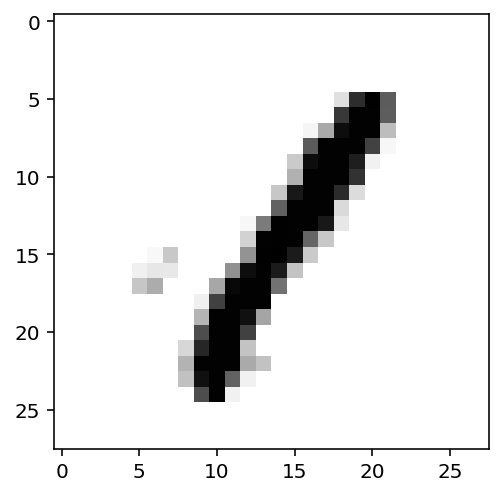

In [5]:
# Let's select a clean image from the dataset
image_pixels = train_clean_X.iloc[4]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

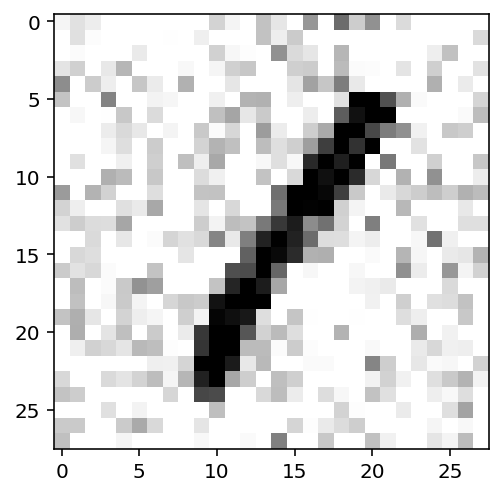

In [6]:
# Let's select a noisy image from the dataset
image_pixels = train_noisy_X.iloc[4]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

In [7]:
train_y.iloc[4]

digit    1
Name: 4, dtype: uint8

In [8]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp: HyperParameters):
    
    # IMPORTANT: This is an example of a very simple undercomplete autoencoder.
    # Your autoencoder can be overcomplete (e.g. the encoding is wider than the input),
    # and it can also be sparse (via L1/L2 norms).
    # In other words, you will probably need to tweak these lines of code.
    
    layers = [
        # Encoder: 50 nodes, Exponential Linear Unit activation
        Dense(
            units=hp.Int('encoder_width', min_value=5, max_value=15, step=5), 
            activation='elu', 
            input_shape=(28 * 28,)
        ),

        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (black) and 1 (white).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=hp.Float(name='learning_rate', min_value=1e-5, max_value=1e0, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

In [9]:
# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.

def train_model(model, epochs):
    history = model.fit(
        x=train_clean_X, 
        y=train_clean_X, 

        # It's a good idea to have low number of epochs,
        # to test the learning process, but not for the final model training.
        epochs=3,

        batch_size=128,
        shuffle=True,
        validation_data=(validate_clean_X, validate_clean_X)
    )
    return history

In [10]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models
# without reseting the seed.

import numpy as np
import tensorflow as tf

np.random.seed(11)
tf.random.set_seed(11)

hp = HyperParameters()
hp.Fixed('encoder_width', value=20)
hp.Fixed('learning_rate', value=0.01)

autoencoder = build_model(hp)
history = train_model(autoencoder, epochs=3)

Epoch 1/3
383/383 [==============================] - 1s 2ms/step - loss: 0.0419 - val_loss: 0.0327
Epoch 2/3
383/383 [==============================] - 1s 2ms/step - loss: 0.0307 - val_loss: 0.0301
Epoch 3/3
383/383 [==============================] - 1s 2ms/step - loss: 0.0289 - val_loss: 0.0286


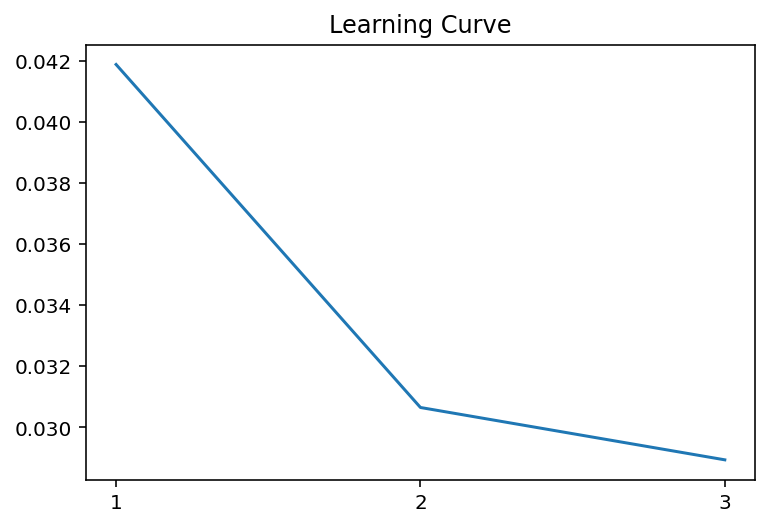

In [120]:
# The fit method returns a history object that
# can be used to plot the learning curve.

learning_curve = pd.Series(history.history['loss'])
learning_curve.index = learning_curve.index + 1

learning_curve.plot(title='Learning Curve')
plt.xticks(learning_curve.index)
plt.show()

In [11]:
from kerastuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='denoiser_hyperop',
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_04'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project denoiser_hyperop/autoencoder_04/oracle.json
INFO:tensorflow:Reloading Tuner from denoiser_hyperop/autoencoder_04/tuner0.json
Search space summary
Default search space size: 2
encoder_width (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 15, 'step': 5, 'sampling': None}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


In [97]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.

tuner.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_clean_X, 
    y=train_clean_X, 
    
    # It's a good idea to have low number of epochs,
    # to test the learning process, but not for the final model training.
    epochs=3,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_clean_X, validate_clean_X)
)

Trial 10 Complete [00h 00m 09s]
val_loss: 0.07275588313738506

Best val_loss So Far: 0.03759303813179334
Total elapsed time: 00h 01m 33s
INFO:tensorflow:Oracle triggered exit


In [12]:
# The following function can be used to view the search summary.
# tuner.results_summary()

In [13]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,encoder_width,learning_rate
trial_id,,,
fb49e29d63ba527bb1da2fdd858ea477,0.037593,10,0.015675
805205f14cb33ad36b7b37b1887b25dd,0.044625,10,0.001837
e6cf09c792f5617eba03c6c542a242e0,0.048902,10,0.001178
b739a9151b32af1847c3a4302bd718a3,0.061630,5,0.100089
07bd400787c06b58f0750dd4dcfae2d7,0.066839,15,0.000128
558858105cdc1d3b18ae4e6e88940575,0.072756,5,0.000127
3df551c1d9a721b7282c6a747fa34ea8,0.078243,5,0.000211
3f65965d2a5e95998848048402554674,0.095781,5,0.000110
76a4e3d016a6c7649a14dcdea5bfdb60,0.156895,10,0.000018


In [27]:
# This returns the best model found during the search.
autoencoder = tuner.get_best_models(num_models=1)[0]

In [28]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters.values
# autoencoder = build_model(best_hyperparameters)

{'encoder_width': 10, 'learning_rate': 0.015675085194668554}

In [29]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

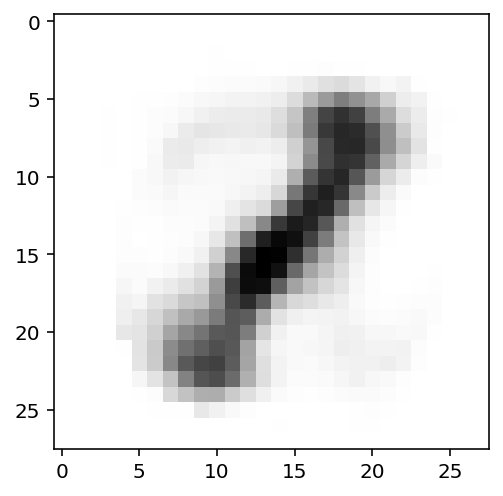

In [30]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[4]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [31]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.03972116716945065

In [32]:
import os 

model_dir = 'denoiser_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_dir}/score_denoised_X.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(autoencoder.to_json()), indent=True))

# Finally, let's save the learned parameters.
autoencoder.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset